# Geopricing with atoti
In this notebook we will explore a pricing use case that combines machine learning algorithms and atoti.  

Through machine learning, we will be able to create clusters for our retail outlets depending on their local competition and current prices.  
This will allow us to simulate various pricing strategies with atoti either by clusters or individual outlets, hence obtain the most competitive pricing.  

For the machine learning, we will need a set of input features for each retail outlets:
- Number of competitors per distance range (1km, 5km, 10km etc)
- Price Index per outlet against its competitors

Price index is a measurement of where a retailer is positioned compared to one or multiple of its competitors.  
Using the output from the machine learning, we can perform the below simulations with atoti:
- Pricing simulations around clusters to obtain the optimised price index against its neighbouring competitors
- Selling price simulation by clusters and retail outlets to align the pricing within the cluster

### Dependencies
Assuming atoti is already installed, let's start by installing the additional libraries required for this notebook to work.

In [1]:
import sys

!conda install --yes --prefix {sys.prefix} folium scipy scikit-learn matplotlib seaborn

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
import atoti as tt
import pandas as pd

Welcome to atoti 0.4.1!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


#### Data loading and cube creation

Let's start by loading our data into atoti stores.

In [3]:
session = tt.create_session()

Normally, we can have the selling price, cost price and quantity of the product sold. Margin hence can be derived, and we can consequently see the impact on margin when price index changes.  
In this notebook however, we simplify the use case by having only the SellingPrice and the total Margin for each product by outlets.  

In [4]:
#  We used pandas to read the selling price here as we will be using it again for price optimisation in the later section.
product_sales_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/outlet_prices.csv"
)

In [5]:
productSales = session.read_pandas(
    product_sales_df,
    keys=["ProductId", "OutletId"],
    store_name="ProductSales",
    types={"ProductId": tt.types.INT, "OutletId": tt.types.INT},
)

productSales.head()

The store has been sampled because there are more than 10000 lines in the files to load. Call Session.load_all_data() to trigger the full load of the data.


SellingPrice    Margin
ProductId OutletId                        
4096.0    1.0              1.920  1959.530
          2.0              2.068  2204.228
          3.0              1.820  1835.545
          4.0              1.825  1641.052
          5.0              2.016  1307.136

Due to the amount of data in this store, the store is sampled by default. We will proceed to load all the data only after we are done modeling the cube.

We will also require the competitors' product pricing against our outlets.  
Note that atoti is able to load csv directly from s3.

In [6]:
competitorPrices = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/competitor_prices.csv",
    keys=["ProductId", "CompetitorOutletId", "OutletId"],
    store_name="CompetitorPrices",
)

competitorPrices.head()

,,,CompetitorPrice
ProductId,CompetitorOutletId,OutletId,
4096.0,101.0,1.0,2.287
4097.0,101.0,1.0,2.320
4098.0,101.0,1.0,2.519
4099.0,101.0,1.0,2.504
4100.0,101.0,1.0,3.309


Since we have the latitude and longitude of the outlets and their competitors, we pre-computed distances in between using the [harvesine formula](https://en.wikipedia.org/wiki/Haversine_formula) and load into the data store.  
Note that another approach would be to use instead something like the [google API](https://developers.google.com/maps/documentation/distance-matrix/intro) to compute distances and durations between two points (thus taking into accounts possible means of transportation).

In [7]:
distance_matrix = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/distance_matrix.csv",
    keys=["OutletId", "CompetitorOutletId"],
    store_name="DistanceMatrix",
    types={"OutletId": tt.types.INT, "CompetitorOutletId": tt.types.INT},
)

distance_matrix.head()

,,Competitor distance KM
OutletId,CompetitorOutletId,
1.0,101.0,0.000000
2.0,101.0,3.145965
3.0,101.0,2.861697
4.0,101.0,3.995581
5.0,101.0,4.547896


We have the key stores necessary for us to generate the data required for machine learning.  
However, we will also load the following stores that will allow us to have a more in-depth analysis:
- Products: Product catalogue
- Outlets: Outlets information such as location
- CompetitorsOutlets: Competitors' outlet information

In [8]:
products = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/products_info.csv",
    keys=["ProductId"],
    store_name="Products",
)

products.head()

,EAN,ProductName,Brand,Size,Unit,Department,SubDepartment,Category,SubCategory
ProductId,,,,,,,,,
4096,3124480000378,"1,5L CANADA DRY PET",CANADA DRY,1.5,L,LIQUIDES,SOFT TRADITIONNELS,TONIC,GINGER ALE
4097,3124480183927,"1,5L SCHWEPPES LEMON PET",SCHWEPPES,1.5,L,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS GAZEUX,PET - PVC
4098,3124480183811,2L OASIS ORANGE PET,OASIS,2,L,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS PLAT,PET - PVC
4099,3124480183828,2L OASIS TROPICAL PET,OASIS,2,L,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS PLAT,PET - PVC
4100,3124480186577,6X33CL OASIS TROPICAL BT,OASIS,6x33,cl,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS PLAT,BOITES


In [9]:
outlets = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/outlets.csv",
    keys=["OutletId"],
    store_name="Outlets",
    types={"OutletId": tt.types.INT},
)

outlets.head()

,OutletName,Adress,ZipCode,City,Country,Latitude,Longitude,Company
OutletId,,,,,,,,
1,MyOutlet Paris 1er,Paris 1er,75001,Paris,France,48.860757,2.342566,MyCompany
2,MyOutlet Paris 15,Paris 15,75015,Paris,France,48.840412,2.312649,MyCompany
3,MyOutlet Paris 18,Paris 18,75018,Paris,France,48.886483,2.344326,MyCompany
4,MyOutlet Paris 12,Paris 12,75012,Paris,France,48.832182,2.375729,MyCompany
5,MyOutlet Paris 16,Paris 16,75016,Paris,France,48.855454,2.280886,MyCompany


In [10]:
competitorOutlets = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/competitor_outlets.csv",
    keys=["CompetitorOutletId"],
    store_name="CompetitorsOutlet",
    types={"CompetitorOutletId": tt.types.INT},
)

competitorOutlets.head()

,CompetitorOutletName,CompetitorOutletAdress,CompetitorOutletZipCode,CompetitorOutletCity,CompetitorOutletCountry,CompetitorOutletLatitude,CompetitorOutletLongitude,CompetitorOutletCompany
CompetitorOutletId,,,,,,,,
101,Concurrent Premium,Paris 1er,75001,Paris,France,48.860757,2.342566,Concurrent Premium
102,Concurrent Premium,Paris 15,75015,Paris,France,48.840412,2.312649,Concurrent Premium
103,Concurrent Premium,Paris 18,75018,Paris,France,48.886483,2.344326,Concurrent Premium
104,Concurrent Premium,Paris 12,75012,Paris,France,48.832182,2.375729,Concurrent Premium
105,Concurrent Premium,Paris 16,75016,Paris,France,48.855454,2.280886,Concurrent Premium


We choose _ProductSales_ as our base store as it contains the key facts for our outlets. Look at [atoti tutorial](https://docs.atoti.io/0.4.1/tutorial/01-Basics.html) to understanding the cube better.   
Correspondingly, we have our _CompetitorPrices_ store that has a many-to-many relationship with our _ProductSales_ as multiple outlets can sell the same products.
 
We can easily setup this many-to-many relationship simply by joining the _CompetitorPrices_ store to our _ProductSales_ store by _ProductId_ and _OutletId_.

In [11]:
price_index_cube = session.create_cube(productSales, "PriceIndexCube")

In [12]:
productSales.join(
    competitorPrices, mapping={"ProductId": "ProductId", "OutletId": "OutletId"}
)

Let's also enrich our cube with extra information about the outlets to create a [snowflake schema](https://www.geeksforgeeks.org/snowflake-schema-in-data-warehouse-model/).

In [13]:
productSales.join(products, mapping={"ProductId": "ProductId"})
productSales.join(outlets, mapping={"OutletId": "OutletId"})
competitorPrices.join(
    competitorOutlets, mapping={"CompetitorOutletId": "CompetitorOutletId"}
)
competitorPrices.join(
    distance_matrix,
    mapping={"CompetitorOutletId": "CompetitorOutletId", "OutletId": "OutletId"},
)

Let's see the final design of our cube.

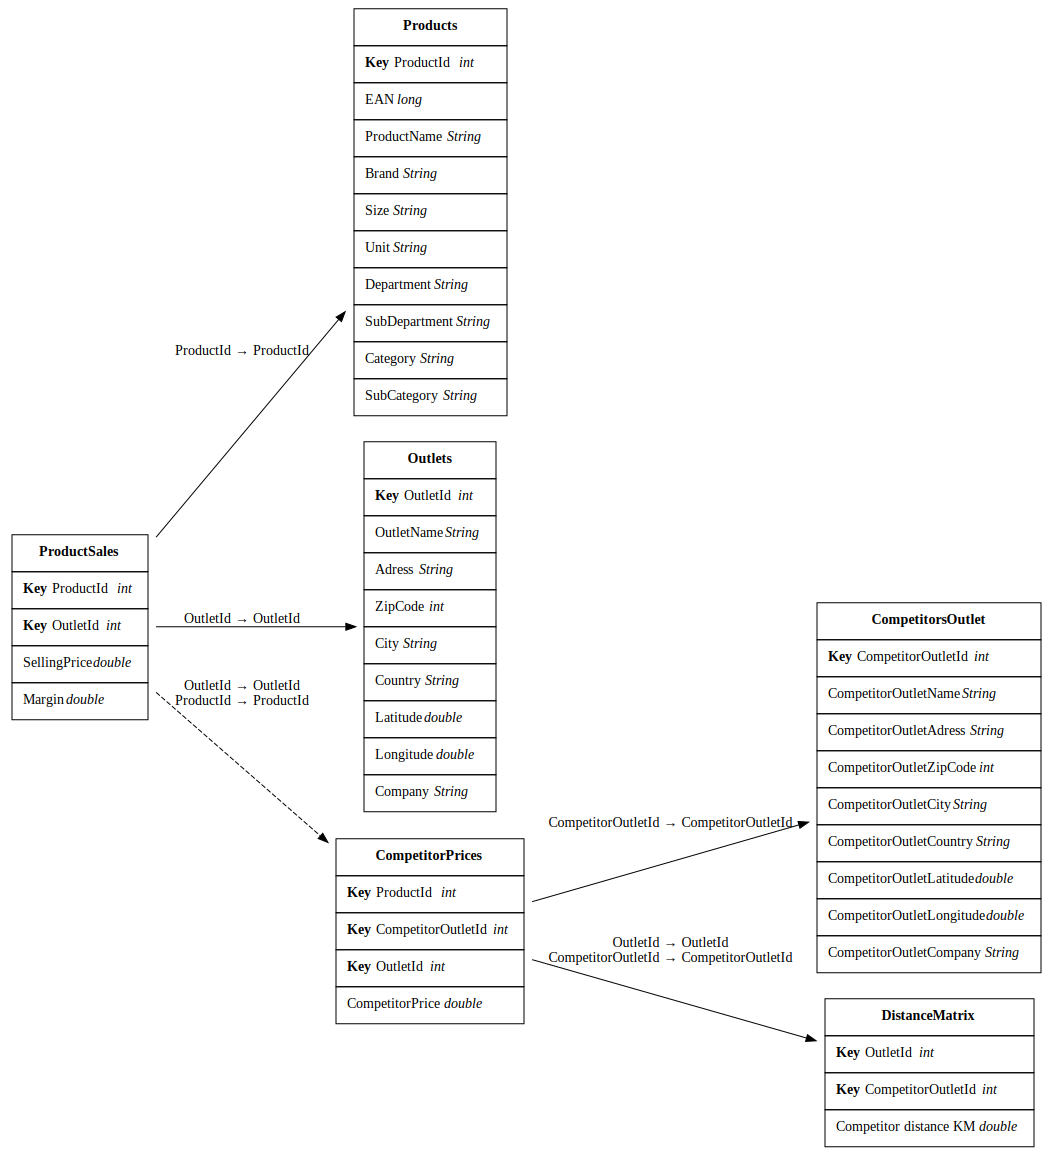

In [14]:
price_index_cube.schema

In [15]:
h = price_index_cube.hierarchies
m = price_index_cube.measures
lvl = price_index_cube.levels

In [16]:
m

Measures()

We can see a _SUM_ and _MEAN_ measure is created columns of type double/float for the base store - _ProductSales_.  
A _VALUE_ measure is created for columns of type double/float in the other referenced stores.  

With the cube created, let's start by computing the price index per outlet.

### 1. Computing the price index per outlet

There are different existing formulas for the price index. The formula we will use in this example compares a product price to the average price found among the local competitors of a particular outlet, measuring at which percentage of this average competitors price the product is.

We will weight the price index indicator by the margin when aggregating above outlet and product level. This is so that we can later optimize the price index for products that contribute the most to the margin. Other commonly used formulas weight by sales quantity or revenue.

#### Price index formula:

# $100 \times \frac{\sum_{o,p \in (Outlets,Products)}\frac{Selling Price(o,p)}{Average Competitor Price(o,p)} \times Margin(o,p)}{\sum_{o,p \in (Outlets,Products)}Margin(o,p)}$  

Let's create a measure to get the mean of _CompetitorPrice_ which will be used to derive the price index.

In [17]:
m["CompetitorPrice.MEAN"] = tt.agg.mean(m["CompetitorPrice.VALUE"])
m["CompetitorPrice.MEAN"].formatter = "DOUBLE[#,###.00]"

We see how the weight price index indicator can be achieved in the next few cells.  
Realize how we are setting the scope on _ProductId_ and _OutletId_? This will ensure the summation of the various measures at the _Outlets_ and _Product_ level as required by the formula.

# ${\sum_{o,p \in (Outlets,Products)}\frac{Selling Price(o,p)}{Average Competitor Price(o,p)} \times Margin(o,p)}$

In [18]:
price_index_numerator = tt.agg.sum(
    (m["SellingPrice.MEAN"] * m["Margin.SUM"]) / m["CompetitorPrice.MEAN"],
    scope=tt.scope.origin(lvl["ProductId"], lvl["OutletId"]),
)

Finally, we calculate the contribution of the product towards the total margin.

In [19]:
m["Price Index"] = price_index_numerator / m["Margin.SUM"]

We can now have the price index per outlet and product.  

atoti allows us to do [modeling with sampled size](https://docs.atoti.io/0.4.1/tutorial/02-Configuration.html#Sampling-mode) of the data.  
As we are currently in sampling mode, let's trigger full data load to do some visualizations.

In [20]:

session.load_all_data()

Let's visualize the price index per outlet.

In [22]:
price_index_cube.visualize("Price index by outlets")

Install and enable the atoti JupyterLab extension to see this widget.

### 2. Computing number of Competitors per Distance Bucket  

There are many ways to do compute the number of competitors per distance buckets. However, we are going to showcase how we can make use of the [`single_value`](https://docs.atoti.io/0.4.1/lib/atoti.html?highlight=single_value#atoti.agg.single_value) function and simulations to create the distance buckets.  

Let's create a measure call `m["Distance Threshold"]` that contains the value for the distance threshold for each bucket and we start by looking at the number of competitors within 1km distance radius from our outlet.

In [22]:
m["Distance Threshold"] = 1

Due to the join to the _CompetitorsPrice_ store, the `m["Contributor.COUNT]` returned is based on the products.
We want to obtain the number of distinct competitors' outlets that sell the same products as us, not the number of products.  

In [23]:
m["Nr Competitors"] = tt.agg.single_value(
    tt.agg.count_distinct(competitorPrices["CompetitorOutletId"]),
    scope=tt.scope.origin(lvl["ProductId"]),
)

We can now use the `where` condition to return the number of distinct competitors selling the same products and is located within our threshold radius.

In [24]:
m["Count within threshold"] = tt.agg.single_value(
    tt.where(
#         (m["Competitor distance km.VALUE"] > 0) & (m["Competitor distance km.VALUE"] < m["Distance Threshold"]), m["Nr Competitors"], 0
        m["Competitor distance KM.VALUE"] < m["Distance Threshold"], m["Nr Competitors"], 0
    ),
    scope=tt.scope.origin(lvl["ProductId"]),
)

m["Competitors Count"] = tt.agg.sum(
    m["Count within threshold"], scope=tt.scope.origin(lvl["CompetitorOutletId"])
)

Naturally we can quickly use Pandas to derive the same value. However, when we use this one time setup together with simulations, we have the below benefits:
- easily add / delete the distance buckets
- ability to drill down on the data for each distance range to perform further analysis

#### Setting up simulation for distance buckets
We setup a simulation where we can replace the threshold value in order to be able to create scenarios for other ranges of distance.  
We name this base scenario "1km".

In [25]:
simulation = price_index_cube.setup_simulation(
    "Distance Simulation", base_scenario="01km", replace=[m["Distance Threshold"]]
)

lvl["Distance Simulation"].comparator = tt.comparator.ASC

We can now easily obtain the number of competitors per area simply by creating a scenario for each distance radius.  
With this, we can easily create new distance buckets to generate different datasets for the machine learning.

In [26]:
simulation.scenarios["05km"] = 5
simulation.scenarios["10km"] = 10
simulation.scenarios["20km"] = 20

Let's do a quick data-viz to see how the number of competitors varies by the distance.

In [28]:
price_index_cube.visualize("Nr of competitors stacked by distance bucket")

Install and enable the atoti JupyterLab extension to see this widget.

How do we systematically make use of this information?   
Let's use the _Competitors Count_ for each distance bucket and _PriceIndex_ computed above - to train a model and clusterize the stores.  
We can extract these data from atoti as shown in the function below:

In [29]:
def get_features():
    # output dataframe for competitors count per area from cube querying
    outlets_competitors_count_per_area = price_index_cube.query(
        m["Competitors Count"], levels=[lvl["OutletId"], lvl["Distance Simulation"]],
    ).reset_index()

    # pivot the table such that each scenario becomes a column
    outlets_competitors_count_per_area = outlets_competitors_count_per_area.pivot(
        index="OutletId", columns="Distance Simulation", values="Competitors Count"
    )

    # output dataframe for price index by outlet from cube querying
    price_index_per_outlet = price_index_cube.query(
        m["Price Index"], levels=[lvl["OutletId"]]
    ).reset_index()

    # merge the 2 dataframe and return the output
    outlets_features = pd.merge(
        outlets_competitors_count_per_area,
        price_index_per_outlet,
        left_on="OutletId",
        right_on="OutletId",
        how="left",
    ).set_index("OutletId")

    return outlets_features

## ML - Outlets clustering using price index and competitors number features
We can use a machine algorithm such as k-means to make clusters with the features (01km, 05km, 10km, 15km, 20km, Price Index) that we obtained from the cube:

In [30]:
outlets_features = get_features()
outlets_features.head()

,01km,05km,10km,20km,Price Index
OutletId,,,,,
1,11,51,66,71,0.986389
2,5,46,61,71,1.043176
3,5,36,71,71,0.960006
4,5,31,61,71,0.969073
5,5,36,56,71,1.030924


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin

sns.set()  # for plot styling

Let's set the number of clusters needed as 5. The number of clusters can increase if the number of outlets is huge.  
We apply the k-mean on the _outlets\_feature_ from above.

In [32]:
number_of_clusters = 5
kmeans = MiniBatchKMeans(number_of_clusters)
kmeans.fit(outlets_features)
new_colors = kmeans.cluster_centers_[kmeans.predict(outlets_features)]
k_means_labels = pairwise_distances_argmin(outlets_features, kmeans.cluster_centers_)
labels = KMeans(number_of_clusters, random_state=0).fit_predict(outlets_features)

Using competitors within 1km as an example, we can now analyze the result of the clustering by pair of features using matplotlib as shown below:

Text(0, 0.5, 'Price Index')

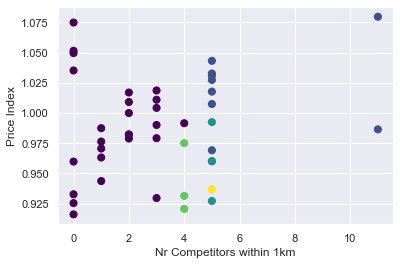

In [33]:
plt.scatter(
    outlets_features.loc[:, "01km"],
    outlets_features.loc[:, "Price Index"],
    c=k_means_labels,
    s=50,
    cmap="viridis",
)

plt.xlabel("Nr Competitors within 1km")
plt.ylabel("Price Index")

In the above plot, each color represents a cluster. We can see that clusters seem to be strongly based on the number of competitors rather than on the price index.  
However, to avoid having to plot every couple of features and understand more quickly what our clusters are, we will use seaborn to have a plot of the clustering result for every pair of features.

In [34]:
outlets_features["Cluster"] = labels
outlets_features.head(5)

,01km,05km,10km,20km,Price Index,Cluster
OutletId,,,,,,
1,11,51,66,71,0.986389,2
2,5,46,61,71,1.043176,2
3,5,36,71,71,0.960006,2
4,5,31,61,71,0.969073,2
5,5,36,56,71,1.030924,2


C:\Apps\miniconda3\envs\atoti-06_22\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Apps\miniconda3\envs\atoti-06_22\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Apps\miniconda3\envs\atoti-06_22\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Apps\miniconda3\envs\atoti-06_22\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Apps\miniconda3\envs\atoti-06_22\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Apps\miniconda3\envs\atoti-06_22

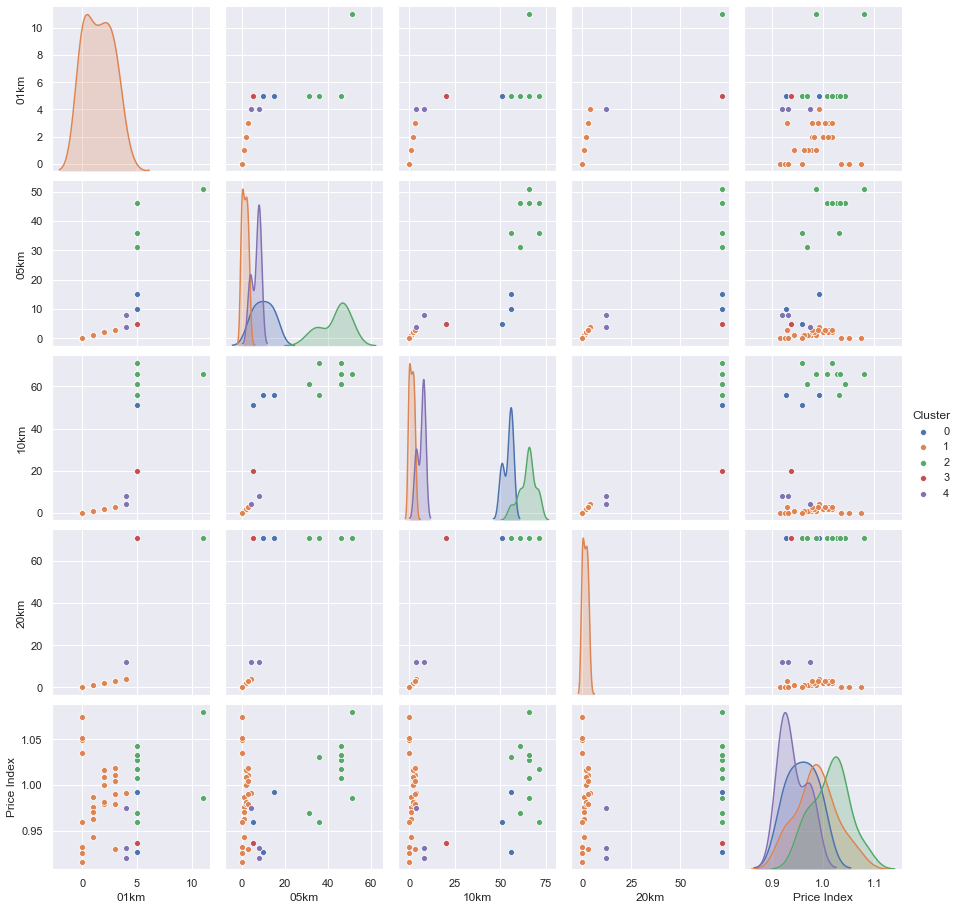

In [35]:
sns.pairplot(data=outlets_features, hue="Cluster")

We can have a better understanding of the clusters with the chart above.  
For example majority of the outlets below to cluster 0, having less than 5 competitors within 1km radius. This cluster generally has index pricing around 1.

Continuing this analysis tells us that:
- Cluster 0 is a small cluster that has slightly lower price index and most competitors are more than 10km away. 
- Cluster 1 is a big cluster with little competitors around.
- Cluster 2 is slight skewed towards a higher price index than the rest while the number of competitors are generally higher even within 5km distance radius.
- Cluster 3 is a small cluster and the number of competitors increases tremendously as the distance radius increases.
- Cluster 4 has a relatively lower price index even though some of the outlets has price index closer to 1. Number of competitors remains about the same across all buckets.

While this gives us an idea of how to position ourselves, we need to put these into context before we can decide on what pricing strategy to apply on it.  
Let's load the new cluster back into the cube to have more in-depth analysis.

### Pricing simulations around clusters
We will now generate new prices using the previous clusters in order to take into account the different competitiveness constraints of the outlets.  

In [36]:
from utils import pricer

Using the clusters generated, the below pricing method tries to reduce the prices if the competitiveness is strong, and on the contrary increase it if there is few competition.  
For instance, cluster 0 and cluster 4 has little competition, hence their price index could be slightly higher than 1.  
The rest of the clusters have more competitors within 10km radius, hence could have their price index at 1 or slightly lower to maintain their competitivity.  

In [37]:
selling_prices_based_on_clusters = pricer.optimize_prices(
    product_sales_df, outlets_features
)

Thanks to atoti built-in simulations capabilities, we can easily create a new scenario for the new pricing by directly loading the price-optimised dataframe.  
All the previously defined KPIs, e.g. the price index, will be re-computed on the fly, enabling us to compare the scenarios and their benefits.

In [38]:
productSales.scenarios["Selling Price Clustering 1"].load_pandas(
    selling_prices_based_on_clusters
)

In [40]:
price_index_cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

Let's load the cluster results obtained from the machine learning model into the cube.

In [41]:
clusters_df = outlets_features[["Cluster"]].reset_index()
clusters_df.OutletId = clusters_df.OutletId.astype("int32")
clusters = session.read_pandas(clusters_df, keys=["OutletId"], store_name="Clusters")

clusters.head(5)

,Cluster
OutletId,
1,2
2,2
3,2
4,2
5,2


In [42]:
outlets.join(clusters)

Let's see the spread of the clusters on the map.

In [44]:
price_index_cube.visualize("Spread of clusters on map")

Install and enable the atoti JupyterLab extension to see this widget.

Interestingly, cluster 1 is distributed all over France except Paris, and mostly they are the only outlet in the neighbourhood that is under our retailer.  
Cluster 4 is a small cluster around Lille, the capital of the Hauts-de-France region in northern France.
The rest of the clusters have outlets under our retailer in close proximity, and most of them spread around Paris.  
The size of the points on the map reflects the number of competitors within 1km - we can see the competition around the city is the highest. 

In the case of cluster 1, the outlet is the only one under the retailer in the neighbourhood. The number of competitors is low, hence price index is less affected by competition.  
Rather, other factors such as variety of products, branding etc could take on a heavier factor on the price index - these are to be considered when applying a pricing strategy for this cluster. Generally, the price index could be higher.

For the rest of the clusters, there are a few considerations. Within the same proximity, the outlets face the same competitors.  
Not only so, consumers can easily detect the price differences of products between the outlets of the same retailer if they are close by one another.  
Hence it make more sense to align their price index and it should be slightly lower to push up its competitivity.

Now, let's visualize the changes in price index for the 5 clusters.

In [46]:
price_index_cube.visualize("Price index optimisation difference")

Install and enable the atoti JupyterLab extension to see this widget.

We can see that the pricing method decreased the price index of outlets in clusters that have high competition in order for them to attract more customers.  
On the contrary it increased the prices in outlets belonging to low competition clusters in order to maximize margin.  
Cluster 1 and 4 for instance, have very few competitors. Hence their selling prices are adjusted higher, resulting in higher price index.

### Selling price simulation by clusters and outlets

Zooming in on cluster 2, we see that _ActiveViam Outlet Paris 6_ has one of the highest compeititon within the cluster.  
<img src="https://data.atoti.io/notebooks/geopricing/cluster2.png" alt="Clustering 1" style="width:300px;"/>

However, the store also has a relatively high price index within the cluster.

In [48]:
price_index_cube.visualize("Price index for cluster 2")

Install and enable the atoti JupyterLab extension to see this widget.

Let's scale down the price index of the outlet using atoti's simulation.

In [49]:
price_simulation = price_index_cube.setup_simulation(
    "Price simulation",
    base_scenario="Selling Price Initial",
    levels=[lvl["Cluster"], lvl["OutletId"]],
    multiply=[m["SellingPrice.MEAN"]],
)

Thanks to atoti built-in simulations capabilities, we can easily create a new scenario for the new pricing by directly loading the price-optimised dataframe.  
All the previously defined KPIs, e.g. the price index, will be re-computed on the fly, enabling us to compare the scenarios and their benefits.

In [50]:
cluster_adjustment = price_simulation.scenarios["Selling Price New"]
cluster_adjustment.append(("2", 7, 0.95),)

In [52]:
price_index_cube.visualize("Price index optimisation difference by scenario")

Install and enable the atoti JupyterLab extension to see this widget.

The price index after price optimization and the outlet adjustment for the outlet looks more aligned now. 

We saw how machine learning helps to identify the clusters based on the amount geographical competitions.  
With this information, we applied different pricing strategy to each cluster using simulations from atoti to understand the impact on the price index.
We also look within a cluster to adjust the pricing of a specific outlet so that it's more attuned to the pricing of the other outlets in the cluster. 

With atoti, we can easily combine the simulations of various factors such as festivals, promotions, seasons etc.
If we have more data such as the quantity of products sold, we can easily see the differences in the margin with each pricing strategy.  
We can thereafter decide on the best pricing from the combination of simulations.

Do have a look at how we can strategize the price index around product class in the [pricing-simulations-around-product-classes](https://github.com/atoti/notebooks/tree/master/retail/pricing-simulations-around-product-classes) notebook and its [corresponding article](https://www.atoti.io/data-dive-how-to-improve-pricing-strategies-with-a-set-of-checkout-receipts/).  
Maybe you can have a go at combining the two strategies to get your own price index!